
# Load the data



In [1]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os 

#first put a shortcut in your drive to the image processing folder

#Choose the image folder you want to try

pipeFolder = '10.8Prepro+glcm+fixed+CorrectedLabels'

RESULTS_DIR = os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Results', 
                        pipeFolder)


RESULTS_DIR_MAIN = os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Results')



MODELS_DIR = os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Results', 
                        'MLModelsFinal2')

DATA_DIR = os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Image Processing and Analysis 2022',
                        'projects',
                        'Calcification Detection',
                        'dataset')


print(os.listdir(RESULTS_DIR))

results_file = os.listdir(RESULTS_DIR)

['20586908_6c613a14b80a8591_MG_R_CC_ANON__fos_glcm.csv', '20586934_6c613a14b80a8591_MG_L_CC_ANON__fos_glcm.csv', '20586960_6c613a14b80a8591_MG_R_ML_ANON__fos_glcm.csv', '20586986_6c613a14b80a8591_MG_L_ML_ANON__fos_glcm.csv', '20587054_b6a4f750c6df4f90_MG_R_CC_ANON__fos_glcm.csv', '20587080_b6a4f750c6df4f90_MG_R_ML_ANON__fos_glcm.csv', '20587148_fd746d25eb40b3dc_MG_R_CC_ANON__fos_glcm.csv', '20587174_fd746d25eb40b3dc_MG_L_CC_ANON__fos_glcm.csv', '20587200_fd746d25eb40b3dc_MG_R_ML_ANON__fos_glcm.csv', '20587226_fd746d25eb40b3dc_MG_L_ML_ANON__fos_glcm.csv', '20587294_e634830794f5c1bd_MG_R_CC_ANON__fos_glcm.csv', '20587320_e634830794f5c1bd_MG_L_CC_ANON__fos_glcm.csv', '20587346_e634830794f5c1bd_MG_R_ML_ANON__fos_glcm.csv', '20587372_e634830794f5c1bd_MG_L_ML_ANON__fos_glcm.csv', '20587466_d571b5880ad2a016_MG_L_CC_ANON__fos_glcm.csv', '20587492_d571b5880ad2a016_MG_R_ML_ANON__fos_glcm.csv', '20587518_d571b5880ad2a016_MG_L_ML_ANON__fos_glcm.csv', '20587544_d571b5880ad2a016_MG_R_CC_ANON__fos_gl

# Import libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler


In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import tree

import pickle
from sklearn.calibration import CalibratedClassifierCV



In [6]:
from sklearn.ensemble import RandomForestClassifier # random forest
from sklearn.metrics import f1_score

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import copy

In [7]:
import os
import cv2
#!pip install fastprogress
from fastprogress import master_bar, progress_bar
#!pip install tqdm
from tqdm.notebook import tqdm_notebook
from skimage import measure

## Functions for loading data

In [8]:
# Read the CSV features given the path and the identifification of the file (key)
def read_results_train_test(path, keys):
  df_result = pd.DataFrame()
  for result in os.listdir(path):
    # Read the files just if they are in format .csv
    if result.split('.')[-1] == 'csv':
      if int(result.split('_')[0]) in list(keys):
        try:
          df = pd.read_csv(path+'/'+result)
          df_result = df_result.append(df)
        except:
          print("Empty file ", result)
  return df_result

In [9]:
# Read all the features files from a specified path
def read_results(path):
  dfs = pd.DataFrame()
  for result in results_file:
    try:
      df = pd.read_csv(path+'/'+result)
    except:
      print("Empty file ", result)

    dfs = dfs.append(df)
  
  return dfs


In [10]:
# Read files and partition them into train and test sets
def train_test_function():
  # standart_partition.csv is a file which contains the keys of the images and if they
  # will be considered for training or for testing
  df_train_test = pd.read_csv(os.path.join('/content',
                                'drive',
                                'MyDrive',
                                'Results',
                                'standard_partitions.csv'), index_col=0)
  train_keys = df_train_test.loc[df_train_test.partition == 'train']['image_id'].values
  test_keys = df_train_test.loc[df_train_test.partition == 'test']['image_id'].values

  # Read the files with specific keys and divide them into train and test datasets
  dfs_train = read_results_train_test(RESULTS_DIR, train_keys)
  dfs_test = read_results_train_test(RESULTS_DIR, test_keys)
  return dfs_train,dfs_test

# **Preprocessing**

We have a unbalanced data problem, therefore we need strategies to deal with this problem while training. In this case, we will use and compare two approaches: Random UnderSampling (RUS) and Successive Enhancement Learning (SEL).

In [11]:
# We will balance data randomly taking  the same amount of 0 and 1 label inputs. There are several options to manage unbalanced data,
# https://towardsdatascience.com/comparing-different-classification-machine-learning-models-for-an-imbalanced-dataset-fdae1af3677f

# The argument not_consider will be used for the SEL approach.
def rus(dfs, not_consider=0):
  # df_negative = dfs.loc[dfs.label == dfs.label.value_counts().idxmax()] #This is for making it more general
  df_negative = dfs.loc[dfs.label == 0] #Take all negative samples from dfs -> label = 0
  print('rus negative initial: ', len(df_negative))
  print('rus negative initial without duplicates: ', len(df_negative.drop_duplicates()))
  #Here we are taking a subset from the 'negative pool' called df_negative with length equal to the number of positive candidates I have
  # not_consider represents an integer number that tells us how many samples we are reusing, so we do not take them out of the negative pool
  if not_consider >= len(dfs.loc[dfs.label == 1]):
    df_0 = pd.DataFrame()
  else:
    # Take a sample of the negative class equal or less than the the positive class
    df_0 = df_negative.sample(len(dfs.loc[dfs.label == 1])-not_consider, random_state = 1) #not_consider is the number of negative samples that I already have and that I misclassified the first time
  print('df_0: ', len(df_0))
  print('append ', len(df_negative.append(df_0)))
  print('df_negative drop no keeping', len(df_negative.drop_duplicates(keep=False)))
  # Delete from the negative pool the samples that I already selected
  df_negative = df_negative.append(df_0).drop_duplicates(keep=False) #df_negative is the samples that have not been used, and have not been selected yet for the training
  print('after drop duplicates with appended: ',len(df_negative))
  dfs_eq = df_0.append(dfs.loc[dfs.label == 1]) #dfs.label.value_counts().idxmin() #Here we are taking the balanced tada
  print("Length of balanced data: ", len(dfs_eq))
  print(dfs_eq['label'].value_counts())
  return dfs_eq, df_negative

In [12]:
def plotFeatures(data):
  #plot the scatter matrix
  pd.plotting.scatter_matrix(data,figsize=(25,25))
  #correlation plot
  corr = data.corr()
  f, ax = plt.subplots(figsize=(25, 25))
  sns.heatmap(corr,annot=True)

# **Feature Engineering**

In [13]:
def pcaAnalysis(components, X_train, X_test):
  pca = PCA(components)
  X_train = pca.fit_transform(X_train)
  X_test = pca.transform(X_test)
  print("PCA variance ratio: ", pca.explained_variance_ratio_)
  print("Total variance Explained by PCA: ", sum(pca.explained_variance_ratio_))
  return X_train, X_test

# **Classification**

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.base import clone
from sklearn.metrics import matthews_corrcoef

In [15]:

def RandomForest(X_train, y_train, cv=5, best_params = dict()):
  if len(best_params) == 0:
    print("Searching for best hyperparameters")
    params = {'criterion': ['gini'],
              'n_estimators': [100], # , 500, 900
              'max_features': ['auto', 'sqrt'],#, 'sqrt', 'log2'
              'max_depth' : [10, 12]}
    grid = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs = -1), param_grid=params, cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_params = grid.best_params_

    print("The best parameters for rf are %s with an accuracy of %0.4f"%(best_params, grid.best_score_))
  
  classifier = RandomForestClassifier(random_state=42, n_jobs = -1)
  
  return classifier, best_params

In [16]:

from sklearn.ensemble import GradientBoostingClassifier # gradient boosting regressor
# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
def GradientBoosting(X_train, y_train, cv=5, best_params = dict()):
  if len(best_params) == 0:
    params = {'learning_rate': [0.1],#0.05, 0.2
              #'min_samples_split': [0.5, 0.8],
              #'min_samples_leaf': [0.1, 0.2, 0.5],
              'max_depth':[8],
              #'max_features':['sqrt'],#'log2'
              #'criterion': ['friedman_mse',  'mae'],
              #'subsample':[0.5, 1.0],
              'n_estimators':[600]}
    grid = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid=params, cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_params = grid.best_params_

    print("The best parameters for gb are %s with an accuracy of %0.4f"%(best_params, grid.best_score_))

  classifier = GradientBoostingClassifier(random_state=42)
  
  return classifier, best_params

In [17]:
from sklearn.ensemble import AdaBoostClassifier 

def AdaBoost(X_train, y_train, cv=5, best_params = dict()):
  if len(best_params) == 0:
    params = {'n_estimators': [600],
              'learning_rate': [0.5]}
    grid = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid=params, cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_params = grid.best_params_

    print("The best parameters for ab are %s with an accuracy of %0.4f"%(best_params, grid.best_score_))
  
  classifier = AdaBoostClassifier(random_state=42)

  return classifier, best_params

In [18]:
from sklearn.linear_model import LogisticRegression

def LogRegre(X_train, y_train, cv=5, best_params = dict()):
  if len(best_params) == 0:
    params = {'multi_class':['multinomial'],
              'solver': ['sag'],#,'saga'
              'penalty': ['l2']}#'elasticnet',
    grid = GridSearchCV(LogisticRegression(random_state=42), param_grid=params, cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_params = grid.best_params_

    print("The best parameters for lrg are %s with an accuracy of %0.4f"%(best_params, grid.best_score_))
  
  classifier = LogisticRegression(random_state=42)
  
  return classifier, best_params

In [19]:
def KNN(X_train, y_train, cv=5, best_params = dict()):
  if len(best_params) == 0:
    params = {'n_neighbors':[3,5]}
    grid = GridSearchCV(KNeighborsClassifier(), param_grid=params, cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_params = grid.best_params_

  classifier = KNeighborsClassifier()

  return classifier, best_params

In [20]:
def DecisionTree(X_train, y_train, cv=5, best_params = dict()):
  classifier = tree.DecisionTreeClassifier()
 

  return classifier, best_params

In [21]:
# This is an example of how to use a Pipe inside a function we are training, as done in Challenge 3 by the professor
def SVC_linear(X_train, y_train, cv=5, best_params = dict()):

  if len(best_params) == 0:
    lower_value_C = 1
    higher_value_C = 10
    n_values = 10
    base = 10
    params = {'C': [1, 3, 5,9.11], 
              'kernel' : ['rbf'],
              'gamma': [2.5, 5, 10]}

    grid = GridSearchCV(SVC(random_state = 42, probability=True), param_grid=params, cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_params = grid.best_params_

    print("The best parameters for svm are %s with an accuracy of %0.4f"%(best_params, grid.best_score_))
  
  classifier = SVC(random_state = 42, probability=True)

  return classifier, best_params

# Training functions

In [22]:
def negative_pool(dataBalanced, dfNegative, hyperOptBalanceData, X_test, y_test, classifier, calibrated=False, hyperParam=dict() ):
  count = 0
  f1_scores = []
  pAUCs = []

  trainBalanceData = dataBalanced.drop('label', axis=1)
  trainBalanceLabel = dataBalanced['label']

  hyperOptTrainData = hyperOptBalanceData.drop('label', axis=1)
  hyperOptLabel = hyperOptBalanceData['label']


  while True:

    #Classification

    if count==0:

      print(f"First iteration {classifier}... looking for best hyperparameters")

      if classifier == 'svm':
        clf, best_params = SVC_linear(hyperOptTrainData, hyperOptLabel,  best_params = {'C': 0.1, 'kernel' : 'rbf'} )
      elif classifier == 'rf':
        clf, best_params = RandomForest(hyperOptTrainData, hyperOptLabel, best_params = {'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'n_estimators': 100})
      elif classifier == 'gb':
        clf, best_params = GradientBoosting(hyperOptTrainData, hyperOptLabel, best_params = {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 600})
      elif classifier == 'adaboost':
        clf, best_params = AdaBoost(hyperOptTrainData, hyperOptLabel, best_params = {'learning_rate': 0.5, 'n_estimators': 600})
      elif classifier == 'logreg':
        clf, best_params = LogRegre(hyperOptTrainData, hyperOptLabel, best_params = hyperParam)
      elif classifier == 'knn':
        clf, best_params = KNN(hyperOptTrainData, hyperOptLabel, best_params = hyperParam)
      elif classifier == 'dt':
        clf, best_params = DecisionTree(hyperOptTrainData, hyperOptLabel,best_params = hyperParam)

      clf.set_params(**best_params)    
      if calibrated:
        clf.fit(trainBalanceData, trainBalanceLabel)
        clf = CalibratedClassifierCV(base_estimator=clf, cv='prefit')
    

    clf.fit(trainBalanceData, trainBalanceLabel)
    pred = clf.predict(trainBalanceData)


    print("TRAIN")
    print('F1-score train: ', f1_score(trainBalanceLabel, pred))
    y_pred_proba_tr = clf.predict_proba(trainBalanceData)[:, 1]
    print('pAUC train: ', roc_auc_score(trainBalanceLabel, y_pred_proba_tr, max_fpr = 0.0001))
    print(confusion_matrix(trainBalanceLabel, pred))

    print("TEST")
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    print('F1-score test: ', f1_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print('pAUC test: ', roc_auc_score(y_test, y_pred_proba, max_fpr = 0.0001))
    print(confusion_matrix(y_test, y_pred))

    pAUCs.append(roc_auc_score(y_test, y_pred_proba, max_fpr = 0.0001))

    misclassified = pd.DataFrame(columns = trainBalanceData.columns)
    labels_pool = []
    print(len(pred))
    print(len(trainBalanceLabel))
    for i in range(len(pred)):
      if (pred[i]==1) & (trainBalanceLabel.iloc[i] == 0): #FP False positive
#        new_row = pd.DataFrame(X_test[i].reshape(1, data.shape[1] ), columns=data.columns)
        new_row = trainBalanceData.iloc[i]
        misclassified = misclassified.append(new_row)
        labels_pool.append(trainBalanceLabel.iloc[i])

    dfPositive = dataBalanced.loc[dataBalanced.label == 1]

    if len(dfPositive)*0.9 >= (len(dfNegative)+len(misclassified)):
      print("Negative pool is too short...")
      print("Len of positive samples: ", len(dfPositive))
      print("Len of negative samples: ", len(dfNegative)+len(misclassified))
      break

    if (len(f1_scores) > 5 and (f1_scores[-1] - f1_scores[-2])< 0.001): 
      print('last ', f1_scores[-1])
      print('second last ', f1_scores[-2])
      print("No significant change in 5 iterations. Escaping")
      break

    dataBalanced, dfNegative = rus(dfPositive.append(dfNegative), len(misclassified)) #Get a new pool of dfNegative
    
    trainBalanceLabel = dataBalanced['label'].append(pd.Series(labels_pool))
    trainBalanceData = dataBalanced.drop(['label'], axis=1).append(misclassified)

    print('Data len: ', len(trainBalanceData))
    print('labels len: ', len(trainBalanceLabel))
    
    count +=1

  return clf, best_params, y_pred_proba, y_pred, np.mean(f1_scores)

In [23]:
from sklearn.decomposition import PCA

# Function for manual 2 fold Cross Validation

def cv_classification(classifier, params, X_train, X_test, y_train, y_test, candidates_train, candidates_test, normals, clf_name, imageKeyLocation, usePCA=False, calibrated=False):
  
  trainDataFull = pd.DataFrame(X_train).copy()
  # StandardScaler is used for scaling the data
  ss_f1 = StandardScaler()
  trainDataFull = pd.DataFrame(ss_f1.fit_transform(trainDataFull), columns=X_train.columns)

  # If PCA is decided to be used in the experiment, transform the data
  if usePCA:
    # Make an instance of the Model considering 95% variability
    pca = PCA(.95)
    trainDataFull = pd.DataFrame(pca.fit_transform(trainDataFull))

  trainDataFull['label'] = y_train

  # Use RUS to obtain a Balanced dataset and a pool of negatives. If the parameter not_considered is not given, the value by default is 0.

  dataBalanced, dfNegative = rus(trainDataFull)
  print("Data Balanced: ", len(dataBalanced))
  print("Negative pool: ",len(dfNegative))

  X_train_f1 = dataBalanced.drop('label', axis=1)
  y_train_f1 = dataBalanced['label']

  # Make a copy of the original classifier before fitting it with data
  clf1 = clone(classifier)
  clf1.set_params(**params)

  if calibrated:
    print("Using Calibrated Classifier")
    clf1.fit(X_train_f1, y_train_f1)
    clf1 = CalibratedClassifierCV(base_estimator=clf1, cv='prefit')

  #Initialization of arrays to keep track of results for each fold
  cvf1Score = []
  cvMccScore = []
  cvpAUCScore = []

  print("******************** RESULTS FOLD 1 *****************************")
  selectedFold = 1
  clf1.fit(X_train_f1, y_train_f1)
  print('TRAIN')
  y_pred_tr_1 = clf1.predict(X_train_f1)
  print(confusion_matrix(y_train_f1, y_pred_tr_1))
  print(f1_score(y_train_f1, y_pred_tr_1))

  y_pred_proba_tr = clf1.predict_proba(X_train_f1)[:, 1]
  print('pAUC train: ', roc_auc_score(y_train_f1, y_pred_proba_tr, max_fpr = 0.0001))

  
  print('TEST')
  prediction_set_1 = pd.DataFrame(ss_f1.transform(X_test.copy()),columns=X_test.columns) 
  if usePCA:
    prediction_set_1 = pd.DataFrame(pca.transform(prediction_set_1))

  y_pred_1 = clf1.predict(prediction_set_1)
  print(confusion_matrix(y_test, y_pred_1))
  print(f1_score(y_test, y_pred_1))
  y_pred_proba = clf1.predict_proba(prediction_set_1)[:, 1]
  print('pAUC test: ', roc_auc_score(y_test, y_pred_proba, max_fpr = 0.0001))

  print(classification_report(y_test, y_pred_1))  
  print('F1 score test: ', f1_score(y_test, y_pred_1, average='binary'))

  df_cm = confusion_matrix(y_test, y_pred_1)
  plt.figure(figsize=(5,5))
  sns.heatmap(df_cm, annot=True, fmt='d') # font size
  plt.show()

  # Save best model
  filename = f'best_model_{clf_name}_{selectedFold}_{pipeFolder}_rus_scaled.pkl'
  pickle.dump(clf1, open(os.path.join(MODELS_DIR,'rus_scaled', filename), 'wb'))
  print(f"Fold {selectedFold} of {clf_name} was saved!")  


  cvf1Score.append(f1_score(y_test, y_pred_1, average='binary'))
  cvMccScore.append(matthews_corrcoef(y_test, y_pred_1))
  cvpAUCScore.append(roc_auc_score(y_test, clf1.predict_proba(prediction_set_1)[:, 1], max_fpr = 0.0001))


  # Take the candidates, groundTruth and normals from the test set to calculate the FROC curve
  candidates_unique = [cand.split('_')[imageKeyLocation] for cand in candidates_test['name'].values.tolist()]
  candidates_unique = list(set(candidates_unique))
  groundTruthShort = [i for i in groundTruths if i.split('_')[0] in candidates_unique]
  print(len(groundTruthShort))
  normals_f1 = [i for i in normals if i in candidates_unique]

  fn_1, dfROC_1, filename_key_1 = calculateFROC(groundTruthShort, normals_f1, candidates_test, y_pred_proba, clf_name, pipeFolder, 'rus_scaled')

  print("*********************** RESULTS FOLD 2 *******************************")
  selectedFold = 2
  trainDataFull = pd.DataFrame(X_test).copy()
  # Create a new instance for StandarScaler in the new fold
  ss_f2 = StandardScaler()
  trainDataFull = pd.DataFrame(ss_f2.fit_transform(trainDataFull), columns=X_test.columns)
  if usePCA:
    # Make an instance of the Model
    pca2 = PCA(.95)
    trainDataFull = pd.DataFrame(pca2.fit_transform(trainDataFull))

  trainDataFull['label'] = y_test

  # Balance the data using function rus. If not_considered is not given, the value by default is 0.
  dataBalanced, dfNegative = rus(trainDataFull)
  print("Data Balanced: ", len(dataBalanced))
  print("Negative pool: ",len(dfNegative))

  X_test_f2 = dataBalanced.drop('label', axis=1)
  y_test_f2 = dataBalanced['label']

  # Make a copy of the original classifier without fitting
  clf2 = clone(classifier)
  clf2.set_params(**params)
  if calibrated:
    print("Using Calibrated Classifier")
    clf2.fit(X_test_f2, y_test_f2)
    clf2 = CalibratedClassifierCV(base_estimator=clf2, cv='prefit')
  clf2.fit(X_test_f2, y_test_f2)

  print('TRAIN')
  y_pred_tr_2 = clf2.predict(X_test_f2)
  print(confusion_matrix(y_test_f2, y_pred_tr_2))
  print(f1_score(y_test_f2, y_pred_tr_2))
  y_pred_proba_tr = clf2.predict_proba(X_test_f2)[:, 1]
  print('pAUC train: ', roc_auc_score(y_test_f2, y_pred_proba_tr, max_fpr = 0.0001))

  print('TEST')
  prediction_set_2 = pd.DataFrame(ss_f2.transform(X_train.copy()), columns=X_train.columns)
  if usePCA:
    prediction_set_2 = pd.DataFrame(pca2.transform(prediction_set_2))

  y_pred_2 = clf2.predict(prediction_set_2)
  print(confusion_matrix(y_train, y_pred_2))
  print(f1_score(y_train, y_pred_2))
  y_pred_proba_2 = clf2.predict_proba(prediction_set_2)[:, 1]
  print('pAUC test: ', roc_auc_score(y_train, y_pred_proba_2, max_fpr = 0.0001))

  print(classification_report(y_train, y_pred_2))  

  print('F1 score: ', f1_score(y_train, y_pred_2, average='binary'))
  df_cm = confusion_matrix(y_train, y_pred_2)
  plt.figure(figsize=(5,5))
  sns.heatmap(df_cm, annot=True, fmt='d') # font size
  plt.show()

  # Save the final model with its respective fold
  filename = f'best_model_{clf_name}_{selectedFold}_{pipeFolder}_rus_scaled.pkl'
  pickle.dump(clf2, open(os.path.join(MODELS_DIR,'rus_scaled', filename), 'wb'))
  print(f"Fold {selectedFold} of {clf_name} was saved!")  

  cvf1Score.append(f1_score(y_train, y_pred_2, average='binary'))
  cvMccScore.append(matthews_corrcoef(y_train, y_pred_2))
  cvpAUCScore.append(roc_auc_score(y_train, clf2.predict_proba(prediction_set_2)[:, 1], max_fpr = 0.0001))
  print("Mean CV_score F1-score: ", np.mean(cvf1Score))

  # Take the candidates, groundTruths and normals from the training fold, which is now used as test.
  candidates_unique = [cand.split('_')[imageKeyLocation] for cand in candidates_train['name'].values.tolist()]
  candidates_unique = list(set(candidates_unique))
  groundTruthShort = [i for i in groundTruths if i.split('_')[0] in candidates_unique]
  print(len(groundTruthShort))
  normals_f2 = [i for i in normals if i in candidates_unique]

  fn_2, dfROC_2, filename_key_2 = calculateFROC(groundTruthShort, normals_f2, candidates_train, y_pred_proba_2, clf_name, pipeFolder, 'rus_scaled')
    
  # Keep track of the best fold for monitoring purposes
  if np.array(cvf1Score).argmax() == 0:  
    best_f1 = f1_score(y_test, y_pred_1)
    best_mcc = matthews_corrcoef(y_test, y_pred_1)
    best_pAUC = roc_auc_score(y_test, y_pred_proba, max_fpr = 0.0001)
    
  else:
    best_f1 = f1_score(y_train, y_pred_2)
    best_mcc = matthews_corrcoef(y_train, y_pred_2)
    best_pAUC = roc_auc_score(y_train, y_pred_proba_2, max_fpr = 0.0001)    


  print("cvf1Score: ", cvf1Score)
  # Join the predictions of each fold in one main predictions file, that will be used for generating the final curve
  dfROC_1 = dfROC_1.append(dfROC_2)

  # The function returns the best fold number, mean of metrics, metrics of the best fold, 
  # final detections file, and the final number of false negatives considering both folds
  return np.array(cvf1Score).argmax(),[np.mean(cvpAUCScore), np.mean(cvf1Score), np.mean(cvMccScore)], [best_pAUC, best_f1, best_mcc], dfROC_1, fn_1+fn_2

# **Scores**

In [24]:
_, _, groundTruths = next(os.walk(os.path.join(DATA_DIR, 'groundtruths')))

In [25]:
import cv2

def calculateFROC(groundTruthsList, normals, candidates, prediction, model, pipeline, balancingStrategy):

  #List needed for counting
  evaluationList = []

  fn = 0 # false negative, for the blobs that do not belong to any component
  positive_candidates = 0

  rowListdfROC = []

  candidates_copy= candidates.copy()
  candidates_copy['prediction'] = prediction

  for imageKey in tqdm_notebook(groundTruthsList):

    evaluationList = []
 
    # Obtain the candidates of a given image
    candidatesImg = candidates_copy.loc[candidates_copy['name'].str.contains(imageKey.split('_')[0], regex=False)]
    candidates_number = len(candidatesImg)

    # Read the groundtruth of the image being analyzed
    mask = cv2.imread(os.path.join(DATA_DIR, 'groundtruths', imageKey), cv2.IMREAD_GRAYSCALE)

    # Obtain labeled connected components (CC) of the groundTruth using the library measure.label, as well as the number of CC found
    blobs = mask > 0.7 * mask.mean() #Thresholding the backgroudnd
    blobs_labels, count = measure.label(blobs, background=0, return_num=True)

    # Dictionary initialization that will be used for counting TP just one time
    dictCounting={}
    for index in range(1, count+1):
      dictCounting[index] = 0
    

    evaluationList = []
    # dictMean is meant for saving just one prediction per candidate in the normal images, 
    # and if there is more than one sample per candidate, they will be appended in a list to only consider one prediction. 
    dictMean = {}

    for index2, candidate in candidatesImg.iterrows():
      sigma = 7

      if (imageKey.split('_')[0] in normals):
        if candidate['name'].split('_')[1] not in dictMean.keys():
          dictMean[candidate['name'].split('_')[1]] = [candidate.prediction]
        else:
          dictMean[candidate['name'].split('_')[1]].append(candidate.prediction)
        continue

      # If the candidate centroid +- sigma goes out of the image, ignore that candidate
      if (((candidate.x - sigma) < 0) or 
        ((candidate.x + sigma) > mask.shape[0]) or 
        ((candidate.y - sigma) < 0) or
        ((candidate.y + sigma) > mask.shape[1])):
        continue

      # Set the corners of a bounding box for each candidate. This will be considered a patch.
      left = int(candidate.x - sigma)
      right = int(candidate.x + sigma)
      top = int(candidate.y - sigma)
      bottom = int(candidate.y + sigma) 

      # Extract the patch from the groundTruth labeled image to know if there are MCs in there (nonzero should be different from zero if this is the case)
      nonzero = cv2.countNonZero(blobs_labels[top:bottom, left: right])

      if nonzero > 0: # It means we found a MC
        # Find all connected components (cc) that intersect with the candidate
        foundCC = [i for i in np.unique(blobs_labels[top:bottom, left: right]) if i!= 0]

        # Keep the maximum prediction of the candidates that intsersect with at least one component
        for cc in foundCC:
          dictCounting[cc] = max(candidate.prediction, dictCounting[cc])

    # If the image is not in normals, check that the MC found area in the groundTruth is less than 15 pixels diameter
    if (imageKey.split('_')[0] not in normals):
      # dictCounting key is the label of the MC found, and value is the prediction, initialized on 0
      for key,value in dictCounting.items():
        if np.sum(blobs_labels == key) > np.floor(np.pi*(15/2.0)**2):
#          print("Too big... discarded")
          continue
        # Value is the prediction of the candidate, or 0 if the candidates did not match
        if value > 0:
            rowListdfROC.append(['TP', value])
        else:
          fn = fn + 1
    else:
      if len(dictMean.keys()) > 0:
        for key, value in dictMean.items():
          # If we have an array of values, consider the maximum prediction for the FP
          rowListdfROC.append(['FP', np.max(np.array(value))])


  filename_key = 'FROC_calculations_{}_pip{}_fn{}_normals{}_{}.csv'.format(model, pipeline, fn, len(normals), balancingStrategy)

  dfROC = pd.DataFrame(rowListdfROC, columns=['type', 'prob'])

  dfROC.to_csv(os.path.join(MODELS_DIR,
                            balancingStrategy,
                            filename_key))
  
  print("File saved as ", filename_key)



  return fn, dfROC, filename_key

In [26]:
import matplotlib.pyplot as plt
from numpy import trapz

def draw_curve(fn, normals, dfROC, name, clf_name, balancingStrategy):

  # Initialize files to save the results
  experiments_results_path = os.path.join(MODELS_DIR, balancingStrategy)
  results_filename = f'results_AUC_{balancingStrategy}_{pipeFolder}.csv'
  confusion_matrix_filename = f'results_ConfMat_{balancingStrategy}_{pipeFolder}.csv'

  # Read the file if it exists or create a new one

  if results_filename not in os.listdir(experiments_results_path):
    results_df = pd.DataFrame(columns=["model", "AUC_TOTAL", "AUC_final_50fPpi", "F1_final"])
    results_df.to_csv(os.path.join(experiments_results_path, results_filename), index=False)
  
    results_confmat = pd.DataFrame(columns=["model", "TP", "FP", "FN", "Total True"])
    results_confmat.to_csv(os.path.join(experiments_results_path, confusion_matrix_filename), index=False)
  
  else:
    results_df = pd.read_csv(os.path.join(experiments_results_path, results_filename))
    results_confmat = pd.read_csv(os.path.join(experiments_results_path, confusion_matrix_filename))

  tpc = 0
  fpc = 0
  tpr = []
  fppi = []

  # Round the probabilities of the detections file to 4 decimals to find thresholds

  dfROC['prob'] = [round(i,4) for i in dfROC['prob'].values]
  # Sort the probabilities in descending order
  dfROC = dfROC.sort_values('prob', ascending=False)

  thresholds = dfROC.prob.unique()
  print('Number of thresholds: ', len(thresholds))
  print(thresholds)

  tp = len(dfROC.loc[dfROC.type == 'TP'])
  print('true positives: ', tp)
  fp = len(dfROC.loc[dfROC.type == 'FP'])
  print('false positives: ',  fp)
  print("Total number of positives: ", tp+fn)

  for i in progress_bar(range(len(thresholds))):

    tpc += len(dfROC.loc[(dfROC.prob > thresholds[i]) & (dfROC.type=='TP')])
    fpc += len(dfROC.loc[(dfROC.prob > thresholds[i]) & (dfROC.type!='TP')])    

    tpr.append( tpc/(tp+fn) )
    fppi.append( fpc/normals )
    tpc = 0
    fpc = 0
  
  # Take a maximum of 50 False Positive per Image (fppi)  
  gamma = [i for i in fppi if i <= 50 ]
  print(max(fppi))
  auc_total = trapz(tpr, x=fppi)/max(fppi)
  print(max(gamma))
  auc_final = trapz(tpr[0:len(gamma)], x=gamma)/max(gamma)

  print('AUC TOTAL:', auc_total)
  fig, ax = plt.subplots()
  ax.plot(fppi, tpr)
  ax.set_xlabel('fPpI', fontsize=15)
  ax.set_ylabel('TPR', fontsize=15)
  ax.grid(True)
  plt.ylim(0,1)
  plt.show()


  print('AUC final:', auc_final)
  fig1, ax1 = plt.subplots()
  ax1.plot(gamma, tpr[0:len(gamma)])
  ax1.set_xlabel('fPpI', fontsize=12)
  ax1.set_ylabel('TPR', fontsize=12)
  ax1.grid(True)
  plt.ylim(0,1)
  plt.xlim(0,50)

  plt.savefig(os.path.join(MODELS_DIR,
                           balancingStrategy, 
                           name+'.eps'), format='eps')
  plt.show()
  
  # Calculate f1_score based on the detections we have
  final_f1 = tp / (tp + (fp + fn)/2)

  # Save the final results in the files
  row_results = [clf_name, auc_total, auc_final, final_f1]
  results_df = results_df.append(pd.DataFrame([row_results], columns=["model", "AUC_TOTAL", "AUC_final_50fPpi", "F1_final"]))
  results_df.to_csv(os.path.join(experiments_results_path, results_filename), index=False)

  confmat_results = [clf_name, tp, fp, fn, tp+fn]
  results_confmat = results_confmat.append(pd.DataFrame([confmat_results], columns=["model", "TP", "FP", "FN", "Total True"]))
  results_confmat.to_csv(os.path.join(experiments_results_path, confusion_matrix_filename), index=False)




In [27]:
# Function to load the models that have already been trained, and use them to predict 
def load_and_predict(selectedFold, classifier_name, balancingStrategy):

  #Reading data
  dfs_train, dfs_test = train_test_function()
  print('Length of train set: ', len(dfs_train))
  print('Length of test set: ', len(dfs_test))

  dfs_tr_hyperopt = dfs_train.sample(frac=0.1, random_state=42)
  dfs_ts_hyperopt = dfs_test.sample(frac=0.1, random_state=42)

  dfs_train = dfs_train.append(dfs_tr_hyperopt).drop_duplicates(keep=False)
  dfs_test = dfs_test.append(dfs_ts_hyperopt).drop_duplicates(keep=False)
  print('Length of train set: ', len(dfs_train))
  print('Length of test set: ', len(dfs_test))

  try:  
    if dfs_train.isnull().values.any():
      colm = dfs_train.columns[dfs_train.isna().any()]
      dfs_train = dfs_train[dfs_train[colm[0]].notna()]

    if dfs_test.isnull().values.any():
      colm = dfs_test.columns[dfs_test.isna().any()]    
      dfs_test = dfs_test[dfs_test[colm[0]].notna()]

    print("Train dfs without nans: ", len(dfs_train))
    print("Test dfs without nans: ",len(dfs_test))

  except Exception as e:
    print("No nan values to drop, or not columns")
    print(e)

  y_train = dfs_train['label'].reset_index(drop=True)
  candidates_train = dfs_train[['name', 'label', 'x', 'y']].reset_index(drop=True)
  X_train = dfs_train.drop(['name', 'label',  'x', 'y'], axis=1).reset_index(drop=True)

  y_test = dfs_test['label'].reset_index(drop=True)
  candidates_test = dfs_test[['name', 'label', 'x', 'y']].reset_index(drop=True)
  X_test = dfs_test.drop(['name', 'label',  'x', 'y'], axis=1).reset_index(drop=True)


  #Obtain train-test datasets
  if selectedFold == 2:
    chosenCandidates = candidates_train
    trainDataFull = pd.DataFrame(X_test).copy()
    ss_f2 = StandardScaler()
    trainDataFull = pd.DataFrame(ss_f2.fit_transform(trainDataFull), columns=X_test.columns)
    trainDataFull['label'] = y_test

    model = pickle.load(open(os.path.join(MODELS_DIR, balancingStrategy, f'best_model_{classifier_name}_{selectedFold}_{pipeFolder}_{balancingStrategy}.pkl'), 'rb'))
    y_pred = model.predict(pd.DataFrame(ss_f2.transform(X_train.copy()), columns=X_train.columns))
    y_pred_proba = model.predict_proba(pd.DataFrame(ss_f2.transform(X_train.copy()), columns=X_train.columns))[:,1]

  else:
    chosenCandidates = candidates_test
    trainDataFull = pd.DataFrame(X_train).copy()
    ss_f1 = StandardScaler()
    trainDataFull = pd.DataFrame(ss_f1.fit_transform(trainDataFull), columns=X_train.columns)
    trainDataFull['label'] = y_train

    model = pickle.load(open(os.path.join(MODELS_DIR, balancingStrategy, f'best_model_{classifier_name}_{selectedFold}_{pipeFolder}_{balancingStrategy}.pkl'), 'rb'))
    y_pred = model.predict(pd.DataFrame(ss_f1.transform(X_test.copy()), columns=X_test.columns))
    y_pred_proba = model.predict_proba(pd.DataFrame(ss_f1.transform(X_test.copy()), columns=X_test.columns))[:,1]


  normals = []
  with open(os.path.join(RESULTS_DIR_MAIN,'normals_final.txt')) as f:
      for line in f:
          normals.append(line[:-1])

  if 'glcm' in pipeFolder:
    imageKeyName = 2
  else:
    imageKeyName = 3

  candidates_unique = [cand.split('_')[imageKeyName] for cand in chosenCandidates['name'].values.tolist()]

  candidates_unique = list(set(candidates_unique))

  groundTruthShort = [i for i in groundTruths if i.split('_')[0] in candidates_unique]

  print(len(groundTruthShort))

  normals = [i for i in normals if i in candidates_unique]

  print("Calculating fROC file...") 
  fn, dfROC, filename_key = calculateFROC(groundTruthShort, normals, chosenCandidates, y_pred_proba, classifier_name, pipeFolder+'_loaded_')
  print(len(dfROC.prob.unique()))
  draw_curve(fn, len(normals), dfROC, filename_key[:-4], classifier_name)


# Auxiliar functions

In [28]:
def generate_fold_results(selected_candidates, normals, imageKeyLocation, trained_clf, y_test, y_pred, y_pred_proba, selectedFold, classifier):

  df_cm = confusion_matrix(y_test, y_pred )
  plt.figure(figsize=(5,5))
  sns.heatmap(df_cm, annot=True, fmt='d') # font size
  plt.show()

  filename = f'best_model_{classifier}_{selectedFold}_{pipeFolder}_negative_pool_scaled.pkl'
  pickle.dump(trained_clf, open(os.path.join(MODELS_DIR,'negative_pool_scaled', filename), 'wb'))
  print(f"Fold {selectedFold} of {classifier} was saved!")  

  candidates_unique = [cand.split('_')[imageKeyLocation] for cand in selected_candidates['name'].values.tolist()]

  candidates_unique = list(set(candidates_unique))
  groundTruthShort = [i for i in groundTruths if i.split('_')[0] in candidates_unique]

  print(len(groundTruthShort))

  normals = [i for i in normals if i in candidates_unique]

  print("Calculating fROC file...")
  fn, dfROC, filename_key = calculateFROC(groundTruthShort, normals, selected_candidates, y_pred_proba, classifier, pipeFolder, 'negative_pool_scaled')

  return fn, dfROC, filename_key

# **Main RUS classification**

This implements the Random Undersampling approach.

Length of train set:  378938
Length of test set:  394560
Length of train set:  341044
Length of test set:  355104
Train dfs without nans:  341044
Test dfs without nans:  355104


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


['Median', '75Percentile', 'sumEntropy', 'sumVariance', 'sumAverage', 'diffVariance']
rus negative initial:  334676
rus negative initial without duplicates:  334655
df_0:  6368
append  341044
df_negative drop no keeping 334647
after drop duplicates with appended:  328279
Length of balanced data:  12736
0    6368
1    6368
Name: label, dtype: int64
Data Balanced:  12736
Negative pool:  328279
Searching for best hyperparameters
The best parameters for rf are {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 100} with an accuracy of 0.9876
rus negative initial:  334676
rus negative initial without duplicates:  334654
df_0:  6368
append  341044
df_negative drop no keeping 334645
after drop duplicates with appended:  328277
Length of balanced data:  12736
0    6368
1    6368
Name: label, dtype: int64
Data Balanced:  12736
Negative pool:  328277
******************** RESULTS FOLD 1 *****************************
TRAIN
[[6053  315]
 [ 483 5885]]
0.9365054105665183
p

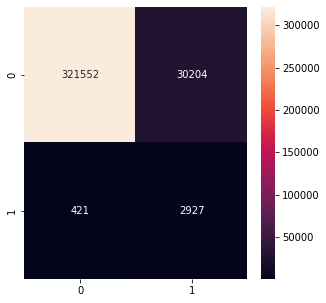

Fold 1 of rf was saved!
200


  0%|          | 0/200 [00:00<?, ?it/s]

File saved as  FROC_calculations_rf_pip10.8Prepro+glcm+fixed+CorrectedLabels_fn455_normals45_rus_scaled.csv
*********************** RESULTS FOLD 2 *******************************
rus negative initial:  351756
rus negative initial without duplicates:  351678
df_0:  3348
append  355104
df_negative drop no keeping 351651
after drop duplicates with appended:  348303
Length of balanced data:  6696
0    3348
1    3348
Name: label, dtype: int64
Data Balanced:  6696
Negative pool:  348303
TRAIN
[[3229  119]
 [ 265 3083]]
0.9413740458015267
pAUC train:  0.7982276652661785
TEST
[[309899  24777]
 [   893   5475]]
0.2990169306389951
pAUC test:  0.502646110727568
              precision    recall  f1-score   support

           0       1.00      0.93      0.96    334676
           1       0.18      0.86      0.30      6368

    accuracy                           0.92    341044
   macro avg       0.59      0.89      0.63    341044
weighted avg       0.98      0.92      0.95    341044

F1 score:  0.2

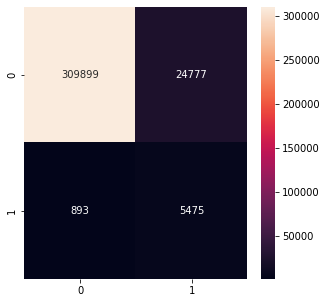

Fold 2 of rf was saved!
Mean CV_score F1-score:  0.22974641043860716
210


  0%|          | 0/210 [00:00<?, ?it/s]

File saved as  FROC_calculations_rf_pip10.8Prepro+glcm+fixed+CorrectedLabels_fn754_normals53_rus_scaled.csv
cvf1Score:  [0.16047589023821926, 0.2990169306389951]
Number of thresholds:  9571
[9.982e-01 9.964e-01 9.963e-01 ... 2.000e-04 1.000e-04 0.000e+00]
true positives:  4429
false positives:  145548
Total number of positives:  5638


1419.3434343434344
49.98989898989899
AUC TOTAL: 0.7457191194147379


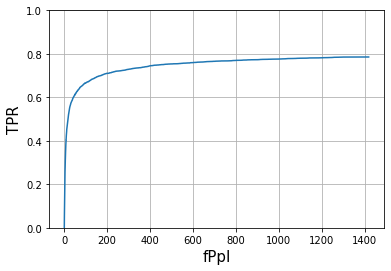

AUC final: 0.5021674610649053


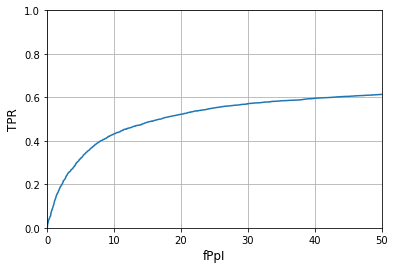

rus negative initial:  334676
rus negative initial without duplicates:  334654
df_0:  6368
append  341044
df_negative drop no keeping 334645
after drop duplicates with appended:  328277
Length of balanced data:  12736
0    6368
1    6368
Name: label, dtype: int64
Data Balanced:  12736
Negative pool:  328277
******************** RESULTS FOLD 1 *****************************
TRAIN
[[6368    0]
 [   0 6368]]
1.0
pAUC train:  1.0
TEST
[[319263  32493]
 [   423   2925]]
0.15090543259557346
pAUC test:  0.5032800915010884
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    351756
           1       0.08      0.87      0.15      3348

    accuracy                           0.91    355104
   macro avg       0.54      0.89      0.55    355104
weighted avg       0.99      0.91      0.94    355104

F1 score test:  0.15090543259557346


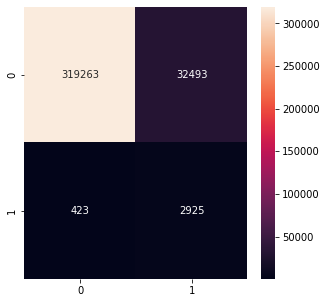

Fold 1 of gb was saved!
200


  0%|          | 0/200 [00:00<?, ?it/s]

File saved as  FROC_calculations_gb_pip10.8Prepro+glcm+fixed+CorrectedLabels_fn455_normals45_rus_scaled.csv
*********************** RESULTS FOLD 2 *******************************
rus negative initial:  351756
rus negative initial without duplicates:  351678
df_0:  3348
append  355104
df_negative drop no keeping 351651
after drop duplicates with appended:  348303
Length of balanced data:  6696
0    3348
1    3348
Name: label, dtype: int64
Data Balanced:  6696
Negative pool:  348303
TRAIN
[[3348    0]
 [   0 3348]]
1.0
pAUC train:  1.0
TEST
[[305728  28948]
 [   867   5501]]
0.26954455251488346
pAUC test:  0.5018489140390576
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    334676
           1       0.16      0.86      0.27      6368

    accuracy                           0.91    341044
   macro avg       0.58      0.89      0.61    341044
weighted avg       0.98      0.91      0.94    341044

F1 score:  0.26954455251488346


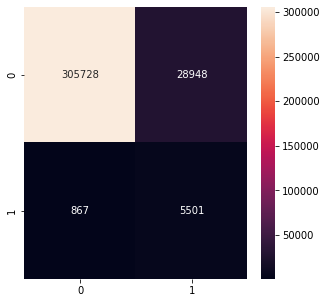

Fold 2 of gb was saved!
Mean CV_score F1-score:  0.21022499255522847
210


  0%|          | 0/210 [00:00<?, ?it/s]

File saved as  FROC_calculations_gb_pip10.8Prepro+glcm+fixed+CorrectedLabels_fn754_normals53_rus_scaled.csv
cvf1Score:  [0.15090543259557346, 0.26954455251488346]
Number of thresholds:  8577
[1.000e+00 9.999e-01 9.998e-01 ... 2.000e-04 1.000e-04 0.000e+00]
true positives:  4429
false positives:  145548
Total number of positives:  5638


1419.4444444444443
49.97979797979798
AUC TOTAL: 0.7426687656301286


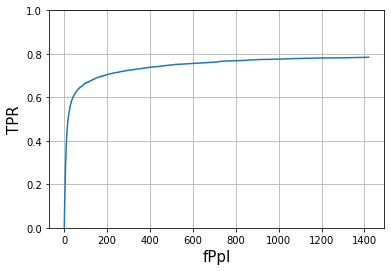

AUC final: 0.48899111239329607


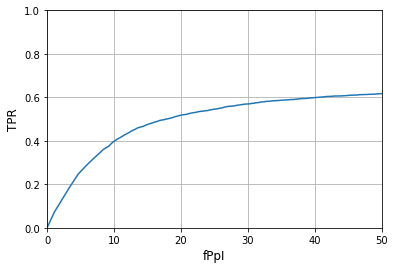

rus negative initial:  334676
rus negative initial without duplicates:  334654
df_0:  6368
append  341044
df_negative drop no keeping 334645
after drop duplicates with appended:  328277
Length of balanced data:  12736
0    6368
1    6368
Name: label, dtype: int64
Data Balanced:  12736
Negative pool:  328277
Using Calibrated Classifier


KeyboardInterrupt: ignored

In [29]:
# def main():
from sklearn.utils import shuffle

balancingStrategy = 'rus_scaled'

# Read the normals file
normals = []
with open(os.path.join(RESULTS_DIR_MAIN,'normals_final.txt')) as f:
    for line in f:
        normals.append(line[:-1])

if 'glcm' in pipeFolder:
  imageKeyName = 2
  usePCA = False
else:
  imageKeyName = 3
  usePCA = True

# List of classifiers that will use Calibration. This list does not change
calibration_classifiers = ['adaboost', 'svm', 'knn', 'dt']

# List of classifiers you want to train the model with.
classifiers = ['rf', 'gb', 'adaboost', 'svm']
best_hyperparameters = dict()
y_pred_proba = []
f1_scores = []

experiments_results_path = os.path.join(MODELS_DIR, balancingStrategy)
results_filename = f'results_{balancingStrategy}_{pipeFolder}.csv'

if results_filename not in os.listdir(experiments_results_path):
  results_df = pd.DataFrame(columns=["model", "pAUC_mean", "f1_mean", "mcc_mean", "pAUC", "f1", "mcc", "selectedFold", "parameters"])
  results_df.to_csv(os.path.join(experiments_results_path, results_filename), index=False)
else:
  results_df = pd.read_csv(os.path.join(experiments_results_path, results_filename))


#Reading data for training and testing
dfs_train, dfs_test = train_test_function()
print('Length of train set: ', len(dfs_train))
print('Length of test set: ', len(dfs_test))

# Take 10% of each dataset (train and test) to look for hyperParameters optimization
dfs_tr_hyperopt = dfs_train.sample(frac=0.1, random_state=42)
dfs_ts_hyperopt = dfs_test.sample(frac=0.1, random_state=42)

# Take out the samples that will be used for hyperparameters optimization from the train and test data
dfs_train = dfs_train.append(dfs_tr_hyperopt).drop_duplicates(keep=False)
dfs_test = dfs_test.append(dfs_ts_hyperopt).drop_duplicates(keep=False)
print('Length of train set: ', len(dfs_train))
print('Length of test set: ', len(dfs_test))

dfs_hyperOpt = shuffle(dfs_tr_hyperopt.append(dfs_ts_hyperopt))

# Manage of NAN values. Remove rows with nan values.
try:  
  if dfs_train.isnull().values.any():
    colm = dfs_train.columns[dfs_train.isna().any()]
    for c in colm:
      dfs_train = dfs_train[dfs_train[c].notna()]

  if dfs_test.isnull().values.any():
    colm = dfs_test.columns[dfs_test.isna().any()]    
    for c in colm:
      dfs_test = dfs_test[dfs_test[c].notna()]

  if dfs_hyperOpt.isnull().values.any():
    colm = dfs_hyperOpt.columns[dfs_hyperOpt.isna().any()]
    for c in colm:
      dfs_hyperOpt = dfs_hyperOpt[dfs_hyperOpt[c].notna()]

  print("Train dfs without nans: ", len(dfs_train))
  print("Test dfs without nans: ",len(dfs_test))

except Exception as e:
  print("No nan values to drop, or not columns")
  print(e)

# DROP THE CORRELATED VARIABLES WITH MORE THAN 0.95
cor_matrix = dfs_hyperOpt.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(to_drop)

dfs_hyperOpt = dfs_hyperOpt.drop([i for i in dfs_hyperOpt.columns if i in to_drop], axis=1)
dfs_train = dfs_train.drop([i for i in dfs_train.columns if i in to_drop], axis=1)
dfs_test = dfs_test.drop([i for i in dfs_test.columns if i in to_drop], axis=1)

# Create the splitting considering X, y and the candidates (name, label, x and y as the centroid)

y_train = dfs_train['label'].reset_index(drop=True)
candidates_train = dfs_train[['name', 'label', 'x', 'y']].reset_index(drop=True)
X_train = dfs_train.drop(['name', 'label',  'x', 'y'], axis=1).reset_index(drop=True)

y_test = dfs_test['label'].reset_index(drop=True)
candidates_test = dfs_test[['name', 'label', 'x', 'y']].reset_index(drop=True)
X_test = dfs_test.drop(['name', 'label',  'x', 'y'], axis=1).reset_index(drop=True)


#Plot features 
#  plotFeatures(data)

# Train dataset balanced
trainDataFull = pd.DataFrame(X_train).copy()
trainDataFull['label'] = y_train

dataBalanced, dfNegative = rus(trainDataFull)
print("Data Balanced: ", len(dataBalanced))
print("Negative pool: ",len(dfNegative))

trainBalanceData = dataBalanced.drop('label', axis=1)
trainBalanceLabel = dataBalanced['label']

# Take the Hyperoptimization set and perform Standard Scaler
hyperOptTrainData = dfs_hyperOpt.drop(['name', 'label',  'x', 'y'], axis=1)
ss = StandardScaler()
hyperOptTrainData = pd.DataFrame(ss.fit_transform(hyperOptTrainData), columns=X_train.columns)
if usePCA:
  # Make an instance of the Model
  pca_hp = PCA(.95)
  hyperOptTrainData = pd.DataFrame(pca_hp.fit_transform(hyperOptTrainData))
hyperOptLabel = dfs_hyperOpt['label']


for classifier in classifiers:
    if classifier == 'svm':
      clf, best_params = SVC_linear(hyperOptTrainData, hyperOptLabel, best_params = {'C': 0.1, 'kernel' : 'rbf'} )
    elif classifier == 'rf':
      clf, best_params = RandomForest(hyperOptTrainData, hyperOptLabel)
    elif classifier == 'gb':
      clf, best_params = GradientBoosting(hyperOptTrainData, hyperOptLabel, best_params = {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 600})
    elif classifier == 'adaboost':
      clf, best_params = AdaBoost(hyperOptTrainData, hyperOptLabel, best_params = {'learning_rate': 0.5, 'n_estimators': 600})
    elif classifier == 'logreg':
      clf, best_params = LogRegre(hyperOptTrainData, hyperOptLabel)
    elif classifier == 'knn':
      clf, best_params = KNN(hyperOptTrainData, hyperOptLabel)
    elif classifier == 'dt':
      clf, best_params = DecisionTree(hyperOptTrainData, hyperOptLabel)

    
    selectedFold, mean_metrics, best_metrics, dfROC, fn = cv_classification(clf, best_params, X_train, X_test, y_train, y_test, 
                                                                            candidates_train, candidates_test, normals, classifier, imageKeyName, usePCA, 
                                                                            classifier in calibration_classifiers) # Last parameter is True or False if the classifier is in calibration classifiers list
 
  # Columns of results file are ["model", "pAUC_mean", "f1_mean", "mcc_mean", "pAUC", "f1", "mcc", "selectedFold", "parameters"]
    results_to_save = [classifier]
    results_to_save.extend(mean_metrics)
    results_to_save.extend(best_metrics)
    results_to_save.append(selectedFold+1)
    results_to_save.append([best_params])
    
  #save Results file in already created file
    results_df = results_df.append(pd.DataFrame([results_to_save], columns=["model", "pAUC_mean", "f1_mean", "mcc_mean", "pAUC", "f1", "mcc", "selectedFold", "parameters"]))
    results_df.to_csv(os.path.join(experiments_results_path, results_filename), index=False)

    best_hyperparameters[classifier] = best_params

    draw_curve(fn, len(normals), dfROC, f'FROC_curve_{classifier}_pip{pipeFolder}_fn{fn}_normals{len(normals)}_{balancingStrategy}', classifier, balancingStrategy)

    del dfROC, fn, results_to_save


# Main Negative Pool Classification

This implements the strategy of Successive Enhancement Learning using a negative pool.

Length of train set:  378938
Length of test set:  394560
Length of train set:  341044
Length of test set:  355104
Train dfs without nans:  341044
Test dfs without nans:  355104


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


['Median', '75Percentile', 'sumEntropy', 'sumVariance', 'sumAverage', 'diffVariance']
rus negative initial:  334676
rus negative initial without duplicates:  334654
df_0:  6368
append  341044
df_negative drop no keeping 334645
after drop duplicates with appended:  328277
Length of balanced data:  12736
0    6368
1    6368
Name: label, dtype: int64
Data Balanced fold 1:  12736
Negative pool fold 1:  328277
rus negative initial:  351756
rus negative initial without duplicates:  351678
df_0:  3348
append  355104
df_negative drop no keeping 351651
after drop duplicates with appended:  348303
Length of balanced data:  6696
0    3348
1    3348
Name: label, dtype: int64
Data Balanced fold 2:  6696
Negative pool fold 2:  348303
Training new model...
******************** RESULTS FOLD 1 **********************
First iteration rf... looking for best hyperparameters
TRAIN
F1-score train:  0.9544265673297931
pAUC train:  0.8581901456881889
[[6140  228]
 [ 347 6021]]
TEST
F1-score test:  0.1584756969

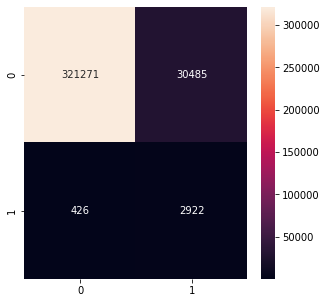

Fold 1 of rf was saved!
200
Calculating fROC file...


  0%|          | 0/200 [00:00<?, ?it/s]

File saved as  FROC_calculations_rf_pip10.8Prepro+glcm+fixed+CorrectedLabels_fn455_normals45_negative_pool_scaled.csv
******************** RESULTS FOLD 2 **********************
First iteration rf... looking for best hyperparameters
TRAIN
F1-score train:  0.9627949183303085
pAUC train:  0.8975456538657279
[[3267   81]
 [ 165 3183]]
TEST
F1-score test:  0.29057473700945974
              precision    recall  f1-score   support

           0       1.00      0.92      0.96    334676
           1       0.17      0.86      0.29      6368

    accuracy                           0.92    341044
   macro avg       0.59      0.89      0.62    341044
weighted avg       0.98      0.92      0.95    341044

pAUC test:  0.502037174598578
[[308788  25888]
 [   885   5483]]
6696
6696
rus negative initial:  348303
rus negative initial without duplicates:  348303
df_0:  3267
append  351570
df_negative drop no keeping 348303
after drop duplicates with appended:  345036
Length of balanced data:  6615
1    33

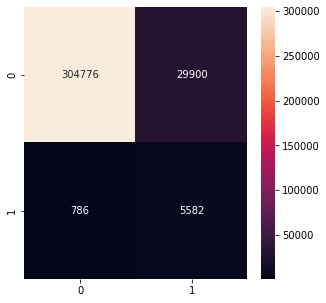

Fold 2 of rf was saved!
210
Calculating fROC file...


  0%|          | 0/210 [00:00<?, ?it/s]

File saved as  FROC_calculations_rf_pip10.8Prepro+glcm+fixed+CorrectedLabels_fn754_normals53_negative_pool_scaled.csv
cvf1Score:  [0.15899877567677867, 0.26676224611708477]
134506
Number of thresholds:  9677
[9.998e-01 9.997e-01 9.996e-01 ... 4.000e-04 1.000e-04 0.000e+00]
true positives:  4429
false positives:  145548
Total number of positives:  5638


1370.3636363636363
49.95959595959596
AUC TOTAL: 0.7433795935218008


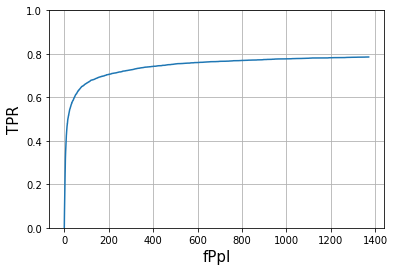

AUC final: 0.49708250309443447


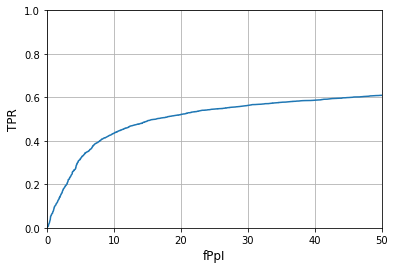

In [30]:
# def main():
from sklearn.utils import shuffle

balancingStrategy = 'negative_pool_scaled'

# Read the normals keys
normals = []
with open(os.path.join(RESULTS_DIR_MAIN,'normals_final.txt')) as f:
  for line in f:
      normals.append(line[:-1])

if 'glcm' in pipeFolder:
  imageKeyName = 2
  usePCA = False
else:
  imageKeyName = 3
  usePCA = True

# Set a list of classifiers that will be used with Calibration. This list does not change.
calibration_classifiers = ['adaboost', 'svm', 'dt', 'knn']

# Set a list of classifiers you want to iterate through to get results
classifiers = [ 'rf']
best_hyperparameters = dict()
y_pred_proba = []
f1_scores = []

# Creating the results file
experiments_results_path = os.path.join(MODELS_DIR, balancingStrategy)
results_filename = f'results_{balancingStrategy}_{pipeFolder}.csv'

if results_filename not in os.listdir(experiments_results_path):
  results_df = pd.DataFrame(columns=["model", "pAUC_mean", "f1_mean", "mcc_mean", "pAUC", "f1", "mcc", "selectedFold", "parameters"])
  results_df.to_csv(os.path.join(experiments_results_path, results_filename), index=False)
else:
  results_df = pd.read_csv(os.path.join(experiments_results_path, results_filename))


#Reading data and spliting in train and test
dfs_train, dfs_test = train_test_function()
print('Length of train set: ', len(dfs_train))
print('Length of test set: ', len(dfs_test))

# Take 10% of each split for hyperoptmimization
dfs_tr_hyperopt = dfs_train.sample(frac=0.1, random_state=42)
dfs_ts_hyperopt = dfs_test.sample(frac=0.1, random_state=42)

dfs_train = dfs_train.append(dfs_tr_hyperopt).drop_duplicates(keep=False)
dfs_test = dfs_test.append(dfs_ts_hyperopt).drop_duplicates(keep=False)
print('Length of train set: ', len(dfs_train))
print('Length of test set: ', len(dfs_test))

dfs_hyperOpt = shuffle(dfs_tr_hyperopt.append(dfs_ts_hyperopt))

# Manage NAN values. Remove rows with nan values.
try:  
  if dfs_train.isnull().values.any():
    colm = dfs_train.columns[dfs_train.isna().any()]
    for c in colm:
      dfs_train = dfs_train[dfs_train[c].notna()]

  if dfs_test.isnull().values.any():
    colm = dfs_test.columns[dfs_test.isna().any()]    
    for c in colm:
      dfs_test = dfs_test[dfs_test[c].notna()]

  if dfs_hyperOpt.isnull().values.any():
    colm = dfs_hyperOpt.columns[dfs_hyperOpt.isna().any()]
    for c in colm:
      dfs_hyperOpt = dfs_hyperOpt[dfs_hyperOpt[c].notna()]

  print("Train dfs without nans: ", len(dfs_train))
  print("Test dfs without nans: ",len(dfs_test))

except Exception as e:
  print("No nan values to drop, or not columns")
  print(e)

# DROP THE CORRELATED VARIABLES
cor_matrix = dfs_hyperOpt.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(to_drop)

dfs_hyperOpt = dfs_hyperOpt.drop([i for i in dfs_hyperOpt.columns if i in to_drop], axis=1)
dfs_train = dfs_train.drop([i for i in dfs_train.columns if i in to_drop], axis=1)
dfs_test = dfs_test.drop([i for i in dfs_test.columns if i in to_drop], axis=1)

# Create the splitting considering X, y and the candidates (name, label, x and y as the centroid)

y_train = dfs_train['label'].reset_index(drop=True)
candidates_train = dfs_train[['name', 'label', 'x', 'y']].reset_index(drop=True)
X_train = dfs_train.drop(['name', 'label',  'x', 'y'], axis=1).reset_index(drop=True)

y_test = dfs_test['label'].reset_index(drop=True)
candidates_test = dfs_test[['name', 'label', 'x', 'y']].reset_index(drop=True)
X_test = dfs_test.drop(['name', 'label',  'x', 'y'], axis=1).reset_index(drop=True)

# Normalization and balancing of data

# Data for FOLD 1
trainDataFull = pd.DataFrame(X_train).copy()
ss_f1 = StandardScaler()
trainDataFull = pd.DataFrame(ss_f1.fit_transform(trainDataFull), columns=X_train.columns)
if usePCA:
  # Make an instance of the Model
  pca = PCA(.95)
  trainDataFull = pd.DataFrame(pca.fit_transform(trainDataFull))

trainDataFull['label'] = y_train
dataBalanced, dfNegative = rus(trainDataFull)
print("Data Balanced fold 1: ", len(dataBalanced))
print("Negative pool fold 1: ",len(dfNegative))


# Data for FOLD 2
trainDataFull_2 = pd.DataFrame(X_test).copy()
ss_f2 = StandardScaler()
trainDataFull_2 = pd.DataFrame(ss_f2.fit_transform(trainDataFull_2), columns=X_test.columns)
if usePCA:
  # Make an instance of the Model
  pca2 = PCA(.95)
  trainDataFull_2 = pd.DataFrame(pca2.fit_transform(trainDataFull_2))    

trainDataFull_2['label'] = y_test

dataBalanced_2, dfNegative_2 = rus(trainDataFull_2)
print("Data Balanced fold 2: ", len(dataBalanced_2))
print("Negative pool fold 2: ",len(dfNegative_2))


# Data for hyperparameters
hyperOptBalanceData = dfs_hyperOpt.drop(['name',  'x', 'y'], axis=1)
ss = StandardScaler()
hyperOptBalanceDataScaled = pd.DataFrame(ss.fit_transform(hyperOptBalanceData.drop('label', axis=1)), columns=X_train.columns)
if usePCA:
  # Make an instance of the Model
  pca_hp = PCA(.95)
  hyperOptBalanceDataScaled = pd.DataFrame(pca_hp.fit_transform(hyperOptBalanceDataScaled))

hyperOptBalanceDataScaled['label'] = hyperOptBalanceData['label'].values

cvf1Score = []
cvMccScore = []
cvpAUCScore = []


for classifier in classifiers:

    print("Training new model...")
    print('******************** RESULTS FOLD 1 **********************')

    prediction_set_1 = pd.DataFrame(ss_f1.transform(X_test.copy()), columns=X_test.columns)
    if usePCA:
      prediction_set_1 = pd.DataFrame(pca.transform(prediction_set_1))


    clf, best_params, y_pred_proba, y_pred, f1_score_1 = negative_pool(dataBalanced.copy(), dfNegative.copy(), hyperOptBalanceDataScaled, 
                                                                      prediction_set_1, y_test, classifier, classifier in calibration_classifiers)
    best_hyperparameters[classifier] = best_params

    cvf1Score.append(f1_score(y_test, y_pred, average='binary'))
    cvMccScore.append(matthews_corrcoef(y_test, y_pred))
    cvpAUCScore.append(roc_auc_score(y_test, y_pred_proba, max_fpr = 0.0001))

    fn_1, dfROC_1, filename_key_1 = generate_fold_results(candidates_test, normals, imageKeyName, clf, y_test, y_pred, y_pred_proba, 1, classifier)
    
    print('******************** RESULTS FOLD 2 **********************')
 
    prediction_set_2 = pd.DataFrame(ss_f2.transform(X_train.copy()), columns=X_train.columns)
    if usePCA:
      prediction_set_2 = pd.DataFrame(pca2.transform(prediction_set_2))

    clf2, best_params, y_pred_proba_2, y_pred_2, f1_score_2 = negative_pool(dataBalanced_2.copy(), dfNegative_2.copy(), hyperOptBalanceDataScaled, 
                                                                            prediction_set_2, y_train, classifier, classifier in calibration_classifiers, best_params)  
    cvf1Score.append(f1_score(y_train, y_pred_2, average='binary'))
    cvMccScore.append(matthews_corrcoef(y_train, y_pred_2))
    cvpAUCScore.append(roc_auc_score(y_train, y_pred_proba_2, max_fpr = 0.0001))

    fn_2, dfROC_2, filename_key_2 = generate_fold_results(candidates_train, normals, imageKeyName, clf2, y_train, y_pred_2, y_pred_proba_2, 2, classifier)


    if np.array(cvf1Score).argmax() == 0:
      best_f1 = cvf1Score[0]
      best_mcc = cvMccScore[0]
      best_pAUC = cvpAUCScore[0]

    else:
      best_f1 = cvf1Score[1]
      best_mcc = cvMccScore[1]
      best_pAUC = cvpAUCScore[1]

    print("cvf1Score: ", cvf1Score)

    row_results = [classifier, np.mean(cvpAUCScore), np.mean(cvf1Score), np.mean(cvMccScore), best_pAUC, best_f1, best_mcc, np.array(cvf1Score).argmax()+1, best_params]
    results_df = results_df.append(pd.DataFrame([row_results], columns=["model", "pAUC_mean", "f1_mean", "mcc_mean", "pAUC", "f1", "mcc", "selectedFold", "parameters"]))
    results_df.to_csv(os.path.join(experiments_results_path, results_filename), index=False)

    dfROC_1 = dfROC_1.append(dfROC_2) 

    print(len(dfROC_1.prob.unique()))
    draw_curve(fn_1+fn_2, len(normals), dfROC_1, f'FROC_curve_{classifier}_pip{pipeFolder}_fn{fn_1+fn_2}_normals{len(normals)}_{balancingStrategy}', classifier, balancingStrategy)

    del clf, y_pred_proba, y_pred, f1_score_1, clf2, y_pred_proba_2, y_pred_2, f1_score_2, best_f1, best_mcc, best_pAUC, dfROC_1, dfROC_2
